## **0. Introduction**

This notebook follows after the "General Linear Model.iypnb" notebook. Aim of this notebook is to conduct the support vector machine. For now, we have 26 z-maps, so one for each contrast, for each session, i.e. 4 * 26 z-maps. We will train the SVM on two sessions and then test the SVM on the remaining two sessions.

## **1. Masking**

First we will need to load the mask. The masks needs to be fetched from the openneuro dataset. This is done with *datalad*.

We cd into the local dataset directory and then use the command:

datalad get sourcedata/sub-01/anat.

The masks are bi-lateral organised, meaning one mask per hemisphere. For starters, the higher visual cortex (HVC) will be the first mask.

In [1]:
import os

os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")
os.listdir()

['sub-01_mask_LH_FFA.nii.gz',
 'sub-01_mask_LH_hV4.nii.gz',
 'sub-01_mask_LH_HVC.nii.gz',
 'sub-01_mask_LH_LOC.nii.gz',
 'sub-01_mask_LH_PPA.nii.gz',
 'sub-01_mask_LH_V1d.nii.gz',
 'sub-01_mask_LH_V1v.nii.gz',
 'sub-01_mask_LH_V2d.nii.gz',
 'sub-01_mask_LH_V2v.nii.gz',
 'sub-01_mask_LH_V3d.nii.gz',
 'sub-01_mask_LH_V3v.nii.gz',
 'sub-01_mask_RH_FFA.nii.gz',
 'sub-01_mask_RH_hV4.nii.gz',
 'sub-01_mask_RH_HVC.nii.gz',
 'sub-01_mask_RH_LOC.nii.gz',
 'sub-01_mask_RH_PPA.nii.gz',
 'sub-01_mask_RH_V1d.nii.gz',
 'sub-01_mask_RH_V1v.nii.gz',
 'sub-01_mask_RH_V2d.nii.gz',
 'sub-01_mask_RH_V2v.nii.gz',
 'sub-01_mask_RH_V3d.nii.gz',
 'sub-01_mask_RH_V3v.nii.gz']

In [2]:
len(os.listdir())

22

We can see that there are 22 masks in total, 11 for each hemisphere. 

In [339]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')
mask_img_R = os.path.join(mask_img_path,'sub-01_mask_RH_LOC.nii.gz')

In [4]:
func_filename_path = '/mnt/c/Users/janos/git/sessions_new/z_maps_3'
func_filename =  os.path.join(func_filename_path,'03_active -1443537.0_z_map.nii.gz')
#os.chdir('/mnt/c/Users/janos/git/sessions/z_maps_2')

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


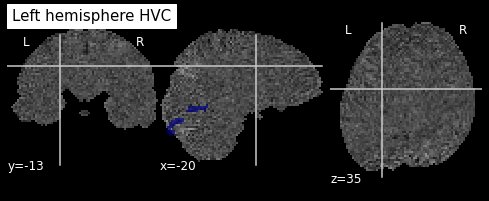

In [340]:
coordinates_func = (-20,-13,35)
from nilearn.plotting import plot_roi
plot_roi(mask_img_L, func_filename,display_mode='ortho',cut_coords=coordinates_func,
         title="Left hemisphere HVC")

Now the next step is to load in the X and Y variables. We will do this by applying Nilearns Niftimasker function on the z_maps we calculated.

Note: We set standardize to *True*, because we want our algorithm to have the best learning behavior. This i

In [341]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L)

This loops helps us in extracting the time series from each z-map.
Also, we append values to the Y list. We have 26 different categories we want to decode. Since there are 4 sessions in total and the categories are the same for each session, we will add a "1" for category one and so on to the Y list.

In [342]:
X = []
Y = []
Sessions = []
category = 1
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            Y.append(category)
            Sessions.append(session)
            category=category+1
            if category == 27:
                category = 1
        
            
        
        
        



In [343]:
import numpy as np
Y = np.array(Y)
Y.shape
Y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26])

In [344]:
import pandas as pd
df =  pd.DataFrame(np.concatenate(X))

In [345]:
X_ = df.to_numpy()
X_.shape

(104, 992)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_)
X_minmax

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=500).fit_transform(X_minmax, Y)
X_new.shape


The shape of our input array X tells us, that we have n_samples = 104 and n_features = 992.
The features relate to the amount of voxels extracted. The samples are the 26 categories multiplied by all 4 sessions.

We now want to test if there are correlations between the features. This can later on help with understanding, which features are more important than other.

In [11]:
X_1 = np.reshape(X_[0],(31,32))
X_11 = np.reshape(X_[25],(31,32))
X_12 = np.reshape(X_[51],(31,32))
X_13 = np.reshape(X_[77],(31,32))


X_2 = np.reshape(X_[1],(31,32))
X_21 = np.reshape(X_[26],(31,32))
X_22 = np.reshape(X_[52],(31,32))
X_23 = np.reshape(X_[78],(31,32))

X_3 = np.reshape(X_[2],(31,32))
X_31 = np.reshape(X_[27],(31,32))
X_32 = np.reshape(X_[53],(31,32))
X_33 = np.reshape(X_[79],(31,32))

X_4 = np.reshape(X_[3],(31,32))
X_41 = np.reshape(X_[28],(31,32))
X_42 = np.reshape(X_[54],(31,32))
X_43 = np.reshape(X_[80],(31,32))




corr_1 =np.corrcoef(X_1)
corr_2 =np.corrcoef(X_2)
corr_3 =np.corrcoef(X_3)
corr_4 =np.corrcoef(X_4)

corr_11 =np.corrcoef(X_11)
corr_12 =np.corrcoef(X_12)
corr_13 =np.corrcoef(X_13)


Text(0.5, 0.98, 'Voxel pattern for four sessions')

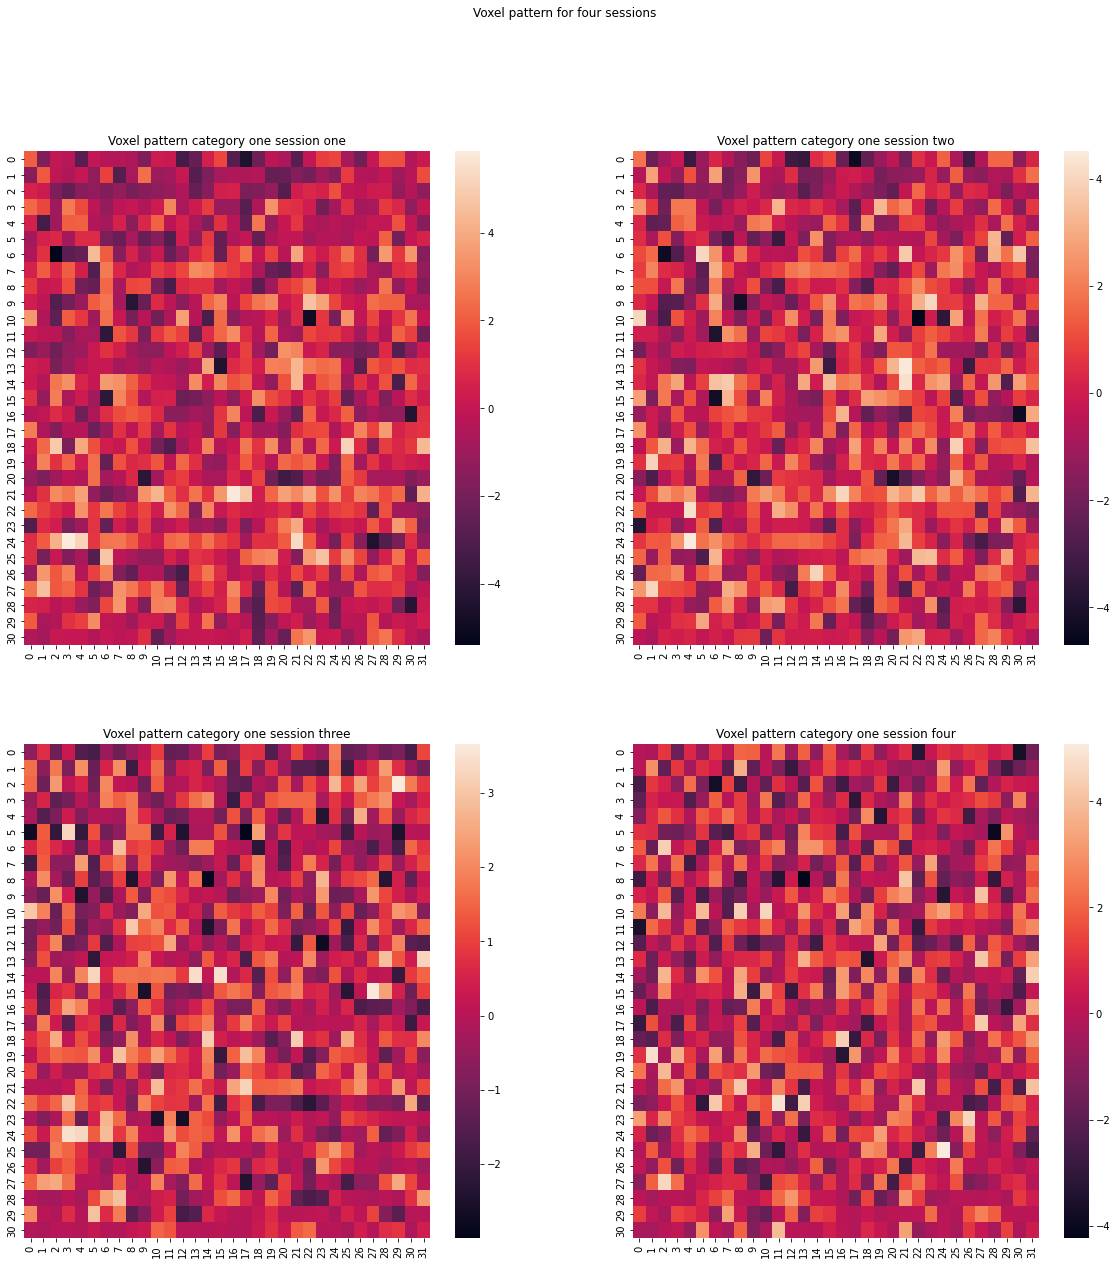

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_1,ax=axis[0,0])
im2= sns.heatmap(X_11,ax=axis[0,1])
im3= sns.heatmap(X_12,ax=axis[1,0])
im4= sns.heatmap(X_13, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session one")
axis[0, 1].set_title("Voxel pattern category one session two")
axis[1, 0].set_title("Voxel pattern category one session three")
axis[1, 1].set_title("Voxel pattern category one session four")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

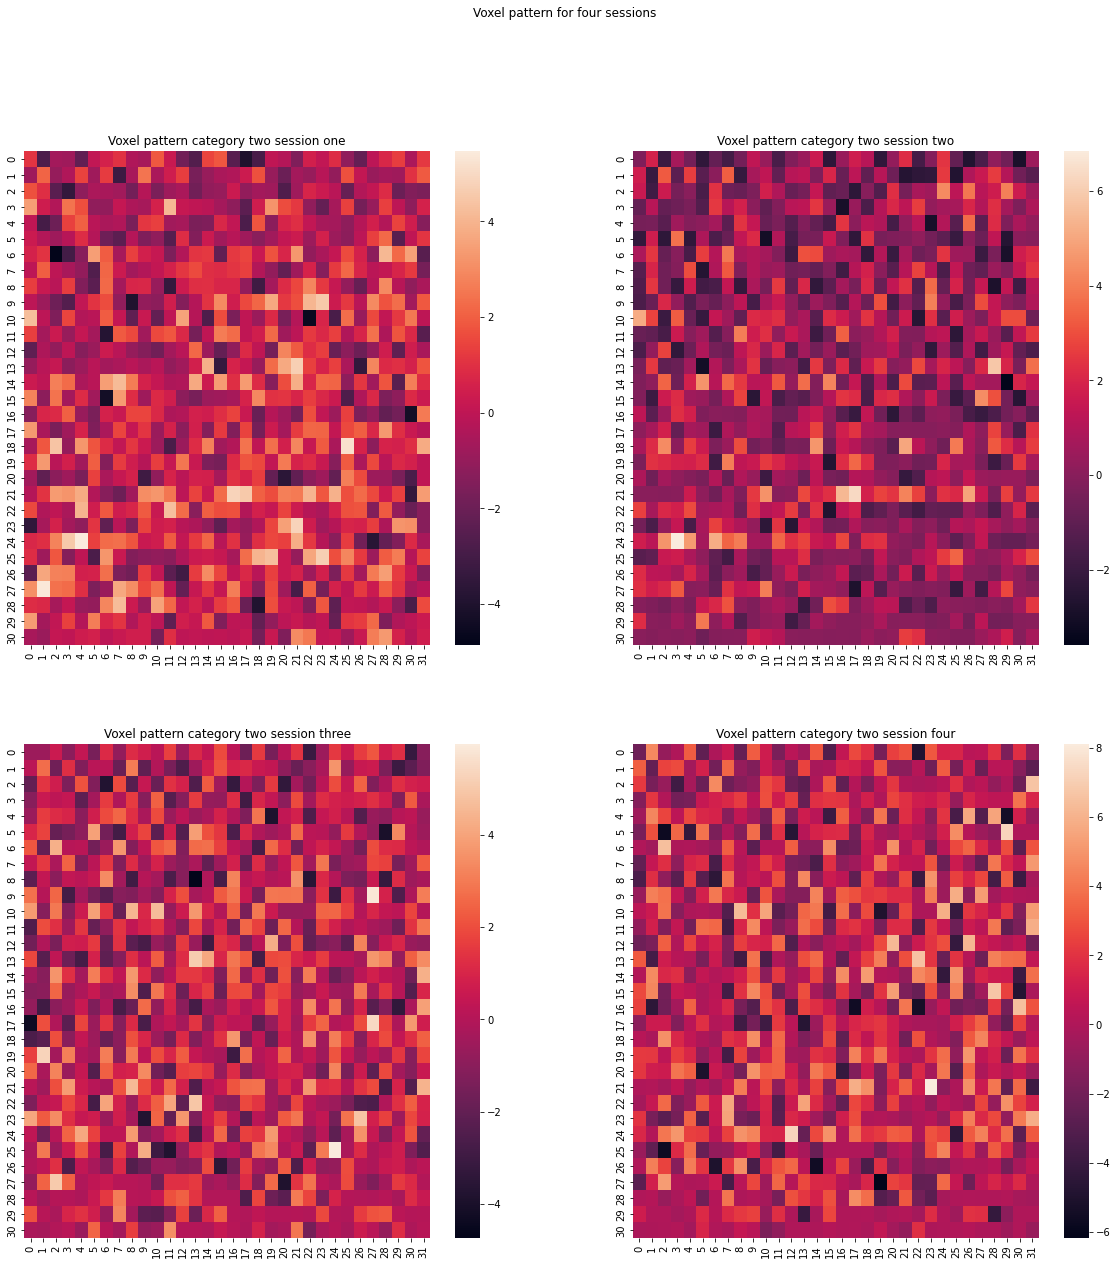

In [13]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_2,ax=axis[0,0])
im2= sns.heatmap(X_21,ax=axis[0,1])
im3= sns.heatmap(X_22,ax=axis[1,0])
im4= sns.heatmap(X_23, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category two session one")
axis[0, 1].set_title("Voxel pattern category two session two")
axis[1, 0].set_title("Voxel pattern category two session three")
axis[1, 1].set_title("Voxel pattern category two session four")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

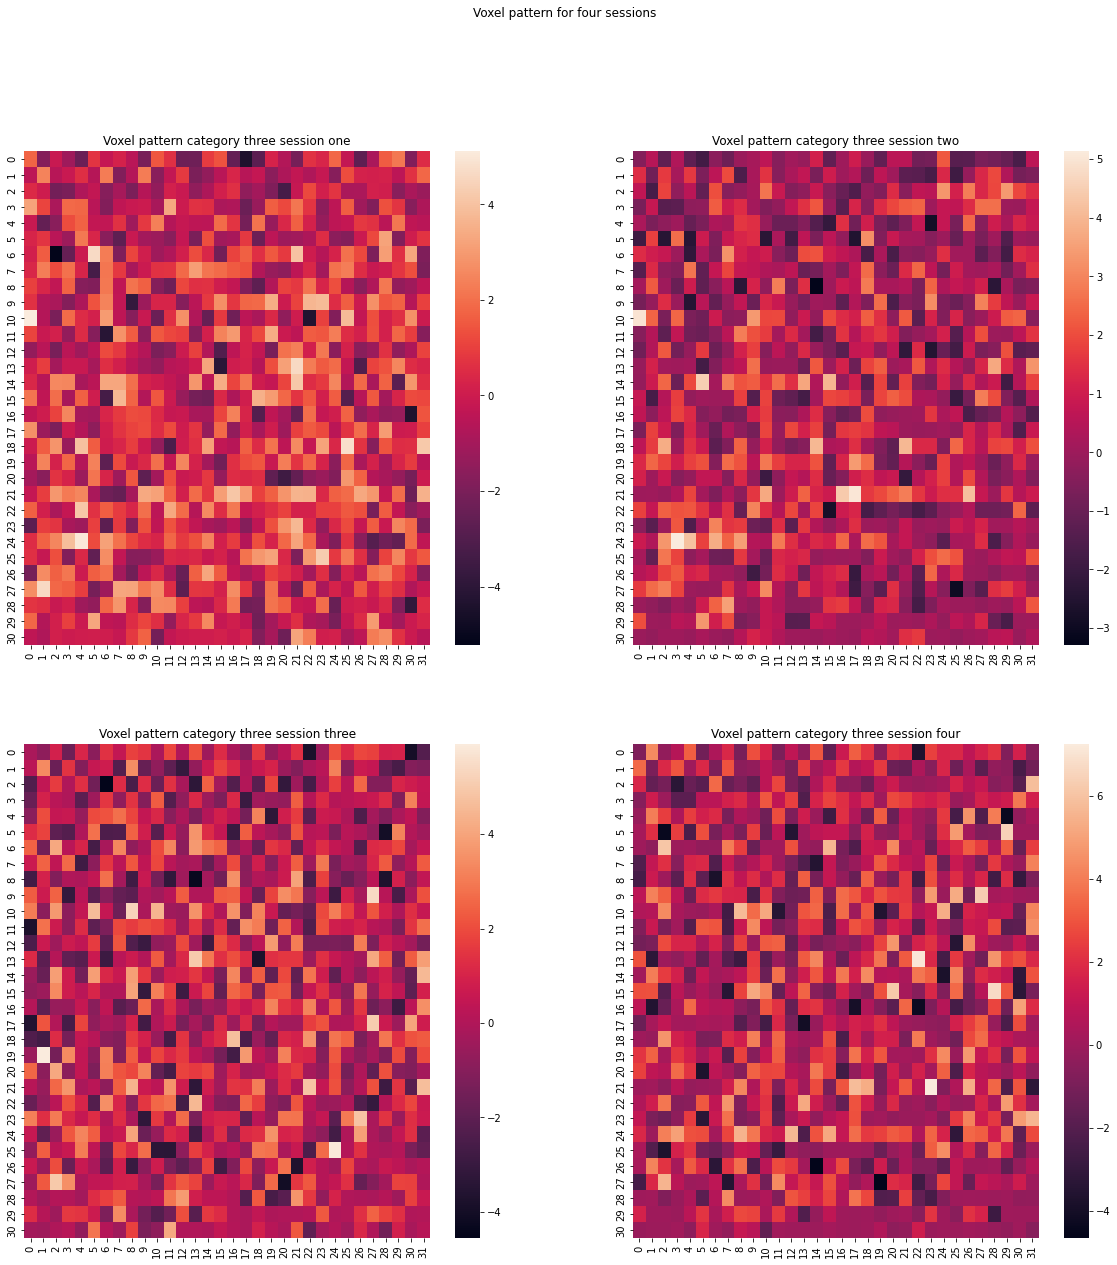

In [14]:

figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_3,ax=axis[0,0])
im2= sns.heatmap(X_31,ax=axis[0,1])
im3= sns.heatmap(X_32,ax=axis[1,0])
im4= sns.heatmap(X_33, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category three session one")
axis[0, 1].set_title("Voxel pattern category three session two")
axis[1, 0].set_title("Voxel pattern category three session three")
axis[1, 1].set_title("Voxel pattern category three session four")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

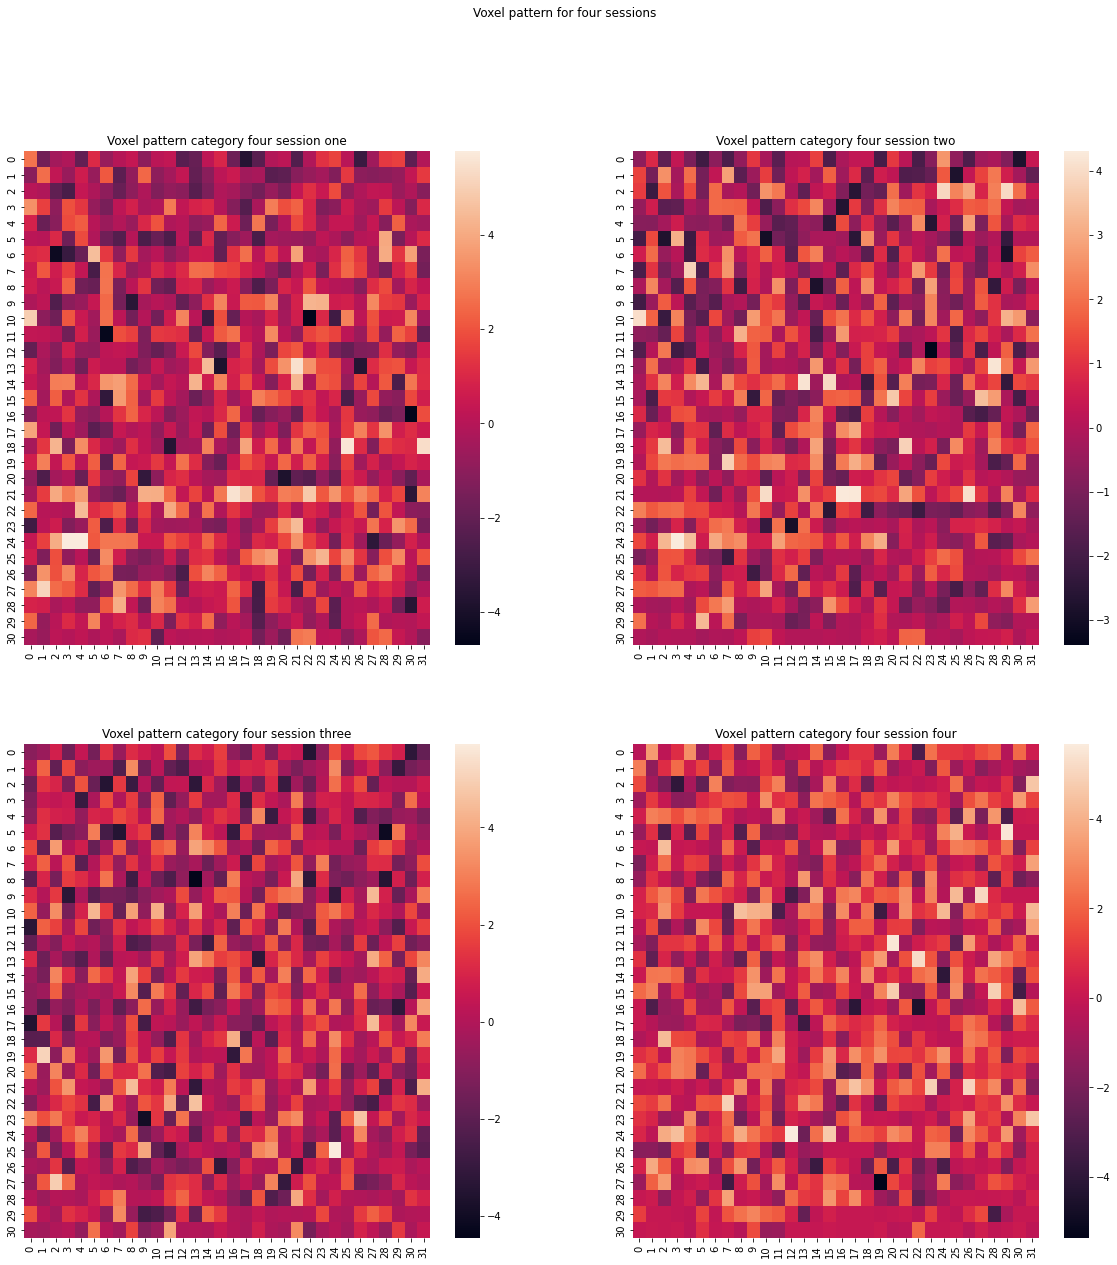

In [32]:

figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_4,ax=axis[0,0])
im2= sns.heatmap(X_41,ax=axis[0,1])
im3= sns.heatmap(X_42,ax=axis[1,0])
im4= sns.heatmap(X_43, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category four session one")
axis[0, 1].set_title("Voxel pattern category four session two")
axis[1, 0].set_title("Voxel pattern category four session three")
axis[1, 1].set_title("Voxel pattern category four session four")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

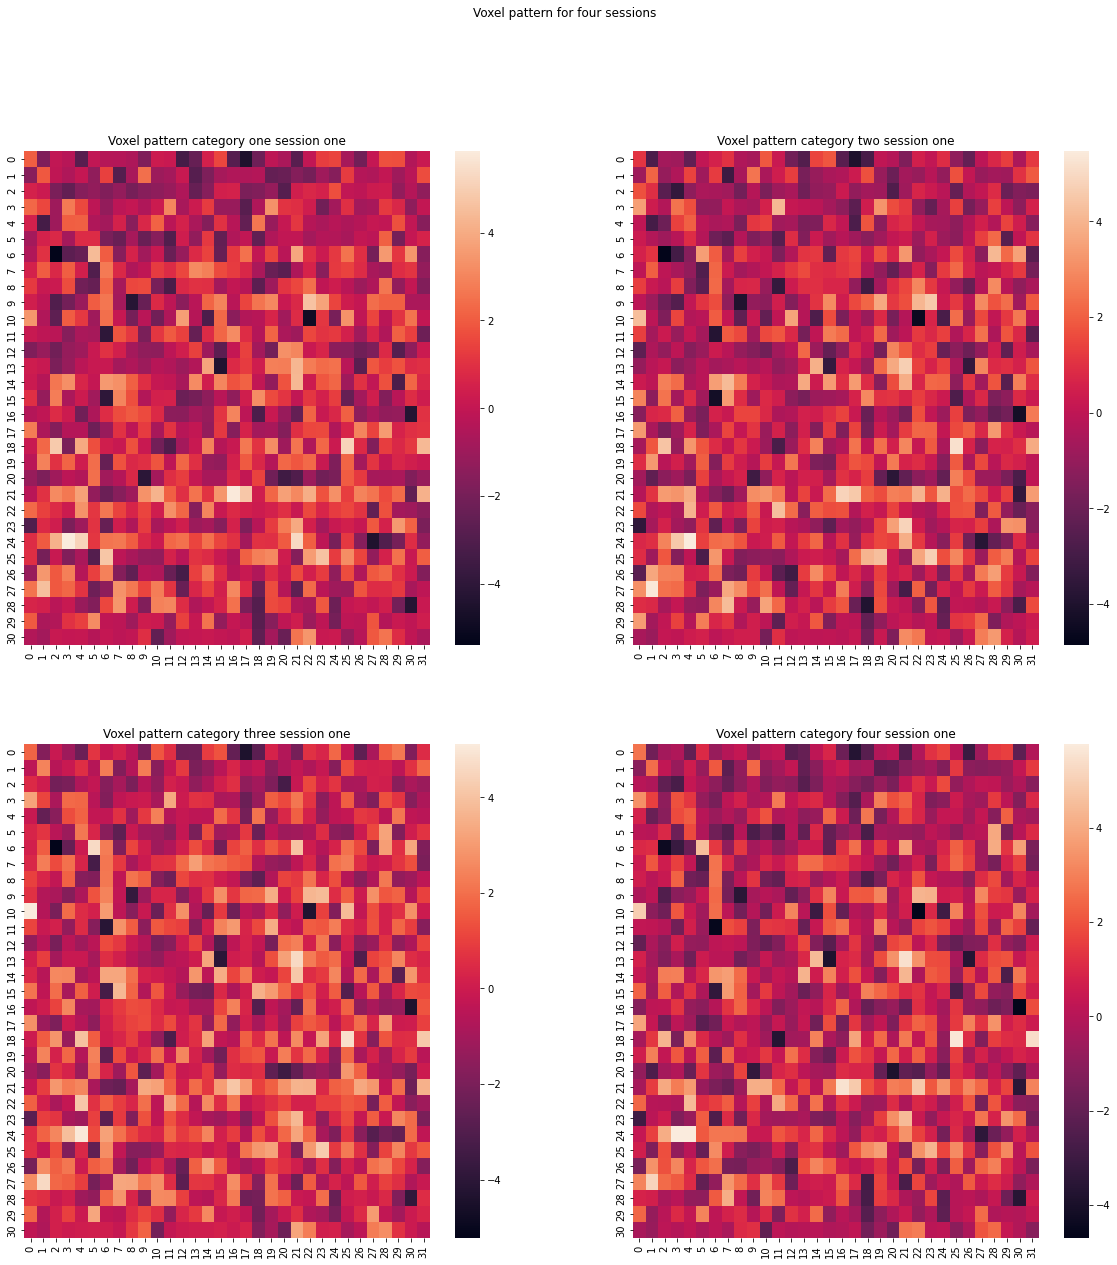

In [15]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_1,ax=axis[0,0])
im2= sns.heatmap(X_2,ax=axis[0,1])
im3= sns.heatmap(X_3,ax=axis[1,0])
im4= sns.heatmap(X_4, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session one")
axis[0, 1].set_title("Voxel pattern category two session one")
axis[1, 0].set_title("Voxel pattern category three session one")
axis[1, 1].set_title("Voxel pattern category four session one")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

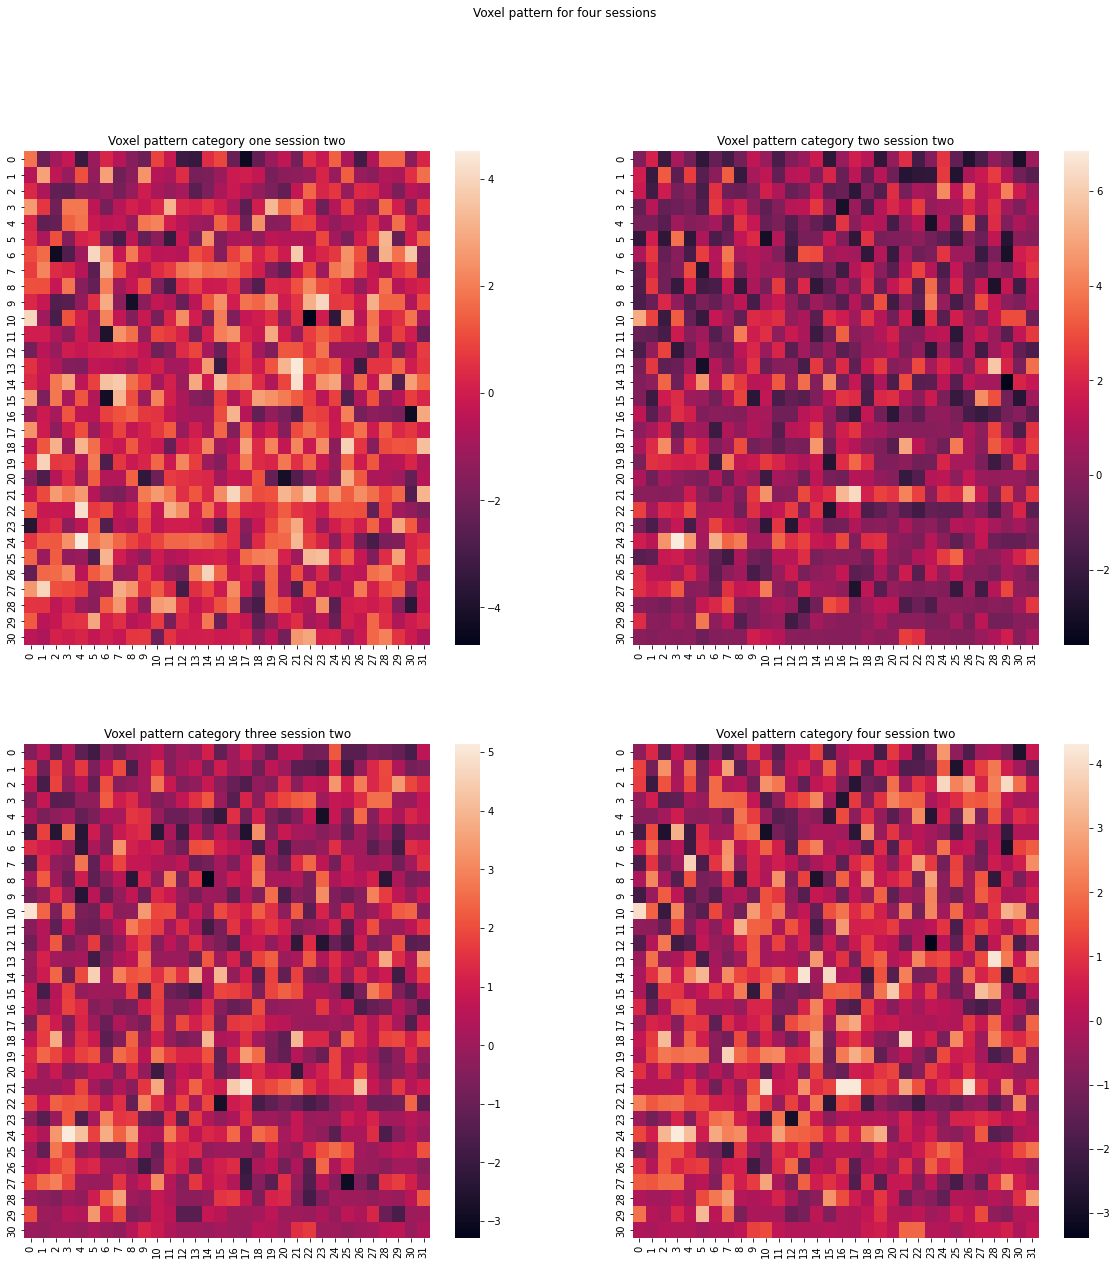

In [29]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_11,ax=axis[0,0])
im2= sns.heatmap(X_21,ax=axis[0,1])
im3= sns.heatmap(X_31,ax=axis[1,0])
im4= sns.heatmap(X_41, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session two")
axis[0, 1].set_title("Voxel pattern category two session two")
axis[1, 0].set_title("Voxel pattern category three session two")
axis[1, 1].set_title("Voxel pattern category four session two")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

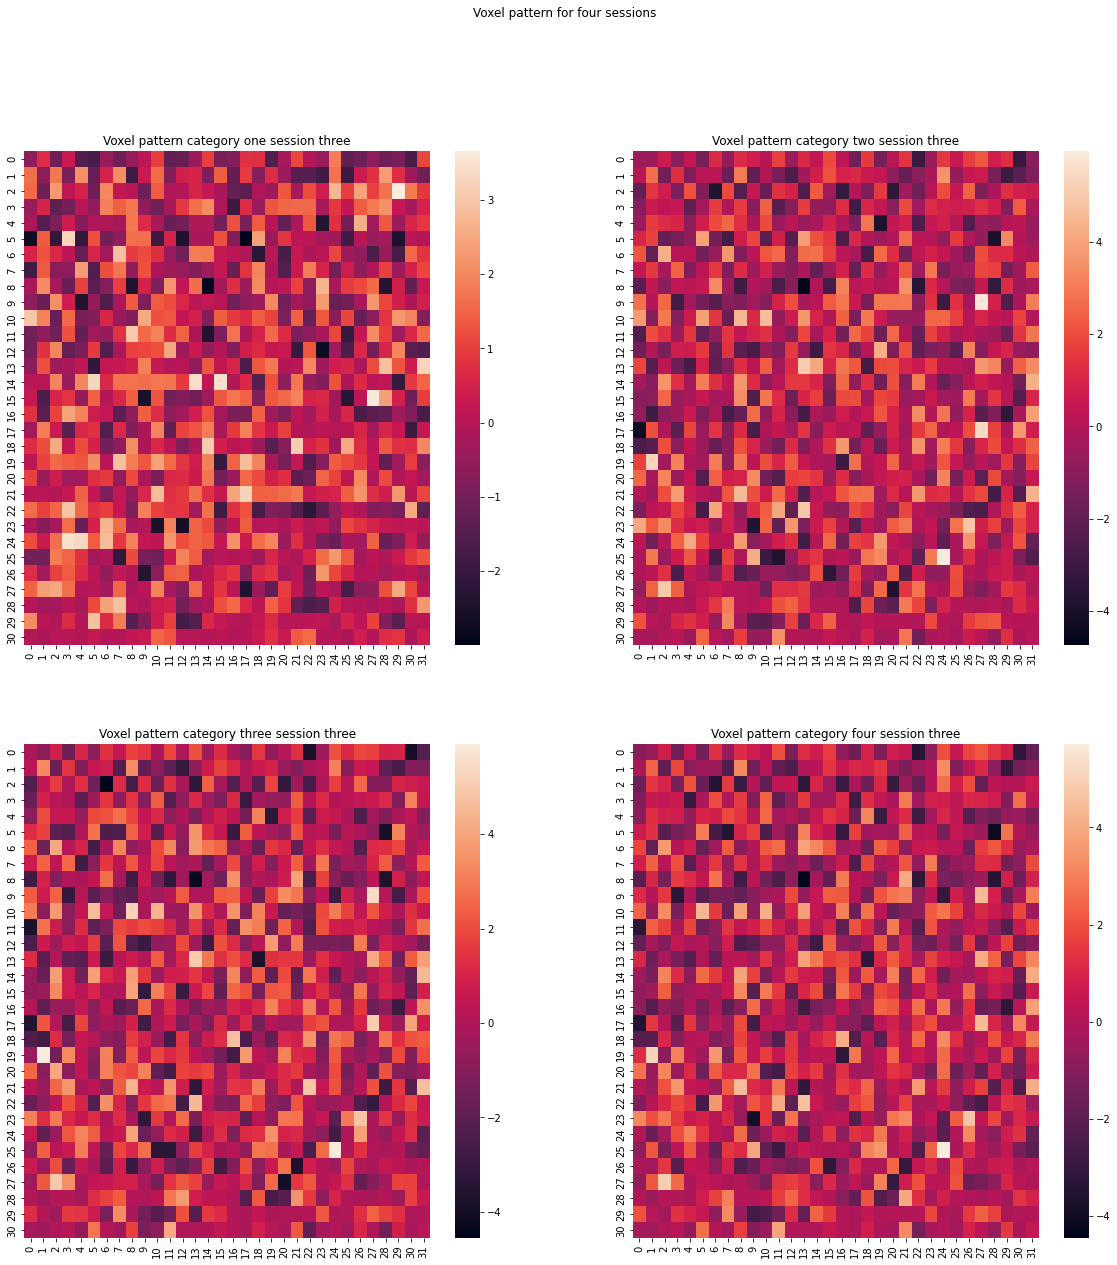

In [30]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_12,ax=axis[0,0])
im2= sns.heatmap(X_22,ax=axis[0,1])
im3= sns.heatmap(X_32,ax=axis[1,0])
im4= sns.heatmap(X_42, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session three")
axis[0, 1].set_title("Voxel pattern category two session three")
axis[1, 0].set_title("Voxel pattern category three session three")
axis[1, 1].set_title("Voxel pattern category four session three")

figure.suptitle('Voxel pattern for four sessions')

Text(0.5, 0.98, 'Voxel pattern for four sessions')

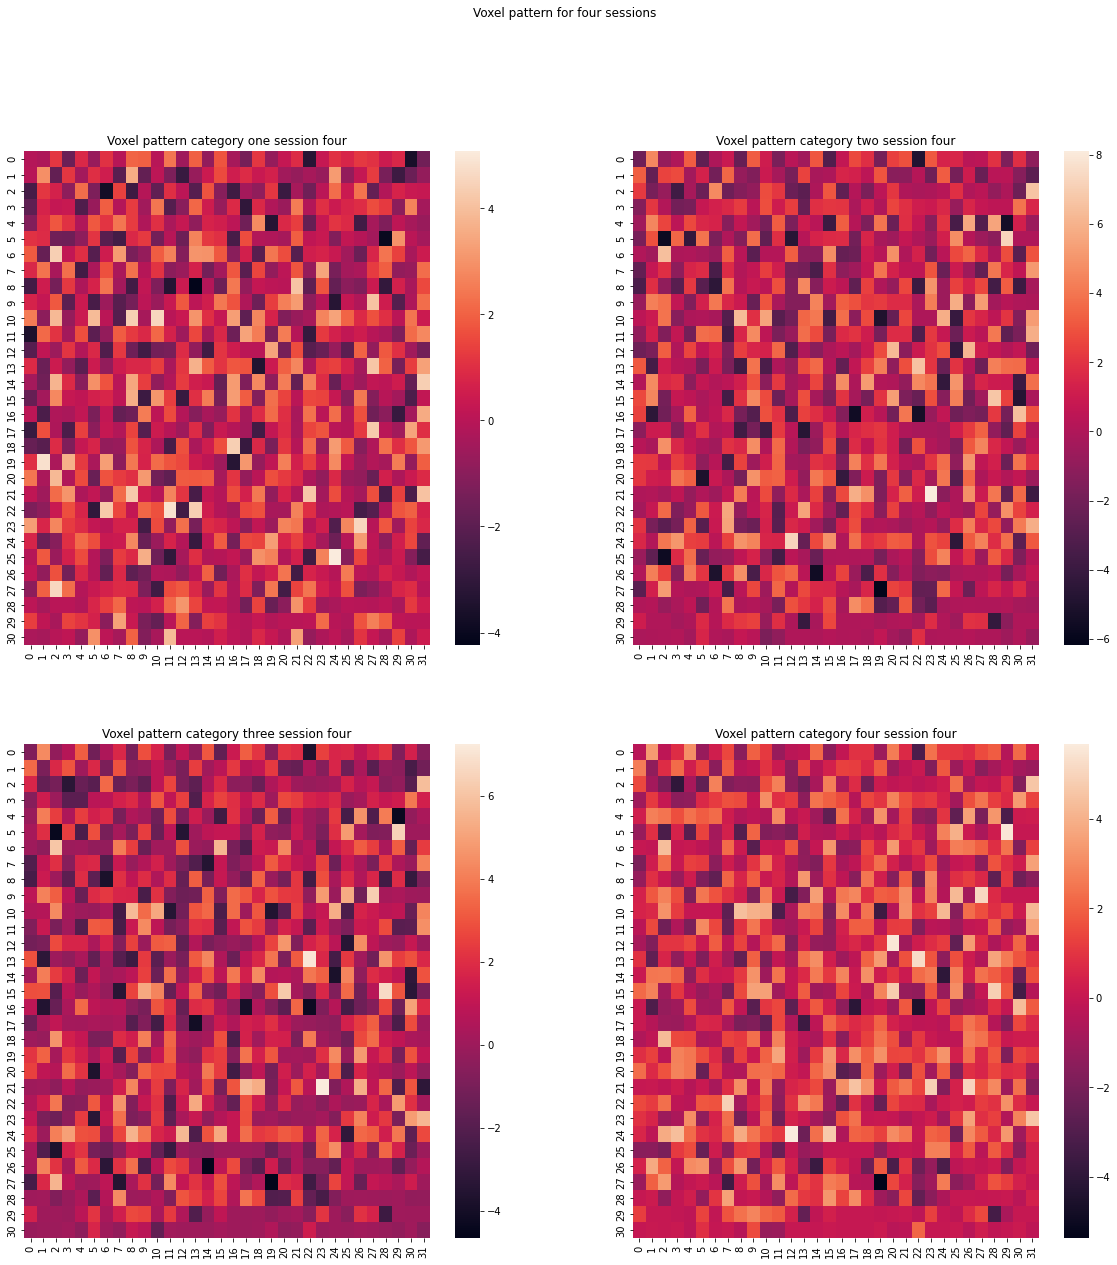

In [31]:
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
im1 = sns.heatmap(X_13,ax=axis[0,0])
im2= sns.heatmap(X_23,ax=axis[0,1])
im3= sns.heatmap(X_33,ax=axis[1,0])
im4= sns.heatmap(X_43, ax=axis[1,1])

#figure.colorbar(orientation='vertical')
axis[0, 0].set_title("Voxel pattern category one session four")
axis[0, 1].set_title("Voxel pattern category two session four")
axis[1, 0].set_title("Voxel pattern category three session four")
axis[1, 1].set_title("Voxel pattern category four session four")

figure.suptitle('Voxel pattern for four sessions')

In [17]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=1000):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 1000))
print("Thanks stackoverflow!")

Top Absolute Correlations
754  755    0.998314
816  817    0.997811
672  673    0.997268
858  859    0.996910
182  310    0.994923
              ...   
683  715    0.942483
4    410    0.942475
330  640    0.942470
544  673    0.942449
649  665    0.942446
Length: 1000, dtype: float64
Thanks stackoverflow!


We now use sklearns train_test_split function to seperate our X and Y variables into training and testing data. We set test_size to 0.3, so we use 70% of the data for training and 30% for testing.

import sklearn.feature_selection as fs
x_anova = SelectKBest(fs.f_classif, k=100).fit_transform(X_, Y)
x_anova.shape

from sklearn.feature_selection import SelectFromModel
lsvc = LogisticRegression(C=0.01, penalty="l2", dual=False).fit(X_, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_)
X_new.shape

In [346]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, Y, test_size=0.2, random_state=42)


In [347]:
X_train.shape

(83, 992)

In [348]:
y_train.shape

(83,)

We see that we will test our model on 72 rows of both X and Y values

In [349]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 1,multi_class='ovr')


In [350]:
model.fit(X_train,y_train)

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

LogisticRegression(C=1, multi_class='ovr')

In [351]:
model.score(X_test, y_test)

0.0

In [352]:
model.predict(X_train)

array([ 4, 23, 25, 19, 21, 16, 17, 15, 10,  8, 12, 26,  1,  3,  2,  6, 11,
        5, 14, 10, 17, 15,  9,  8, 18, 17, 18,  2, 20,  7, 26, 22, 24, 14,
       25,  4, 18, 13,  9,  4,  7, 16, 11, 13,  6,  3, 25, 19, 21, 22, 10,
       23, 19, 16,  7, 23, 12,  6, 24,  7, 20,  8, 12, 24, 12,  4,  2,  1,
       22,  3, 24, 10, 17, 23,  9,  5, 21,  9, 20, 15, 15, 26, 25])

In [353]:
y_train

array([ 4, 23, 25, 19, 21, 16, 17, 15, 10,  8, 12, 26,  1,  3,  2,  6, 11,
        5, 14, 10, 17, 15,  9,  8, 18, 17, 18,  2, 20,  7, 26, 22, 24, 14,
       25,  4, 18, 13,  9,  4,  7, 16, 11, 13,  6,  3, 25, 19, 21, 22, 10,
       23, 19, 16,  7, 23, 12,  6, 24,  7, 20,  8, 12, 24, 12,  4,  2,  1,
       22,  3, 24, 10, 17, 23,  9,  5, 21,  9, 20, 15, 15, 26, 25])

In [368]:
y_pred_train = model.predict(X_train)
cf_matrix_train = confusion_matrix(y_train, y_pred_train)

sns.heatmap(cf_matrix_train, annot = True)

ValueError: Found input variables with inconsistent numbers of samples: [83, 21]

In [364]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

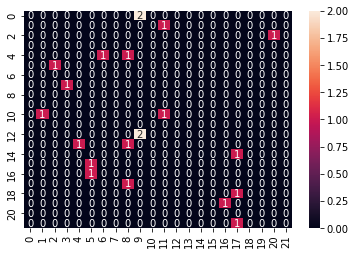

In [365]:
sns.heatmap(cf_matrix, annot=True)

In [366]:
model.predict(X_test)

array([ 9,  9, 10, 12,  9, 20,  5, 19,  2, 10,  6,  3, 12,  6, 20,  7, 25,
        4, 10, 10, 20])

In [367]:
y_test

array([ 5, 14, 13,  2, 20, 16, 14, 22, 11,  1, 19,  6, 11, 18, 26,  5,  3,
        8, 13,  1, 21])

In [25]:
model.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])